In [2]:
#import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_motion = pd.read_csv('clustering_columns.csv')

In [4]:
df_motion.head()

,inMotionAtBallSnap,init_rel_y_dis,end_rel_y_dis,overall_y_change,init_rel_x_dis,end_rel_x_dis,overall_x_change,motion_s_avg,frames_in_motion,max_x_rel_pos,min_x_rel_pos,max_y_rel_pos,min_y_rel_pos,dis_line_start,dis_line_end,passed_fb
0,1,983,201,782,-244,-649,405,359.935484,31,409,-2,-3,1069,668,-114,0
1,1,2,-320,322,-475,-256,-219,242.291667,24,0,-248,0,542,-325,-647,0
2,1,1082,582,500,-151,-117,-34,255.388889,18,4,-29,0,481,945,445,1
3,0,12,-469,481,-264,-116,-148,8.000000,1,2,-165,495,0,-324,-805,0
4,1,1042,419,623,-98,-331,233,413.200000,15,238,0,0,621,746,123,1


In [5]:
from sklearn.preprocessing import StandardScaler

#standardize the variables before conducting PCA
scaler = StandardScaler()
scaler.fit(df_motion)
df_motion_scaled = scaler.transform(df_motion)

In [10]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=8)

In [12]:
pca.fit(df_motion_scaled)

PCA(n_components=8)

In [14]:
x_pca = pca.transform(df_motion_scaled)

In [16]:
df_motion_scaled.shape

(3350, 16)

In [18]:
x_pca.shape

(3350, 8)

In [20]:
# Perform PCA (already done in your code)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)
print("Total Variance Explained:", np.sum(explained_variance))

Explained Variance Ratio: [0.29276852 0.23408384 0.14079124 0.08401625 0.07633956 0.05569724
 0.04315593 0.02340095]
Total Variance Explained: 0.9502535244039478


C:\Users\etien\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\etien\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\etien\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\etien\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\etien\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

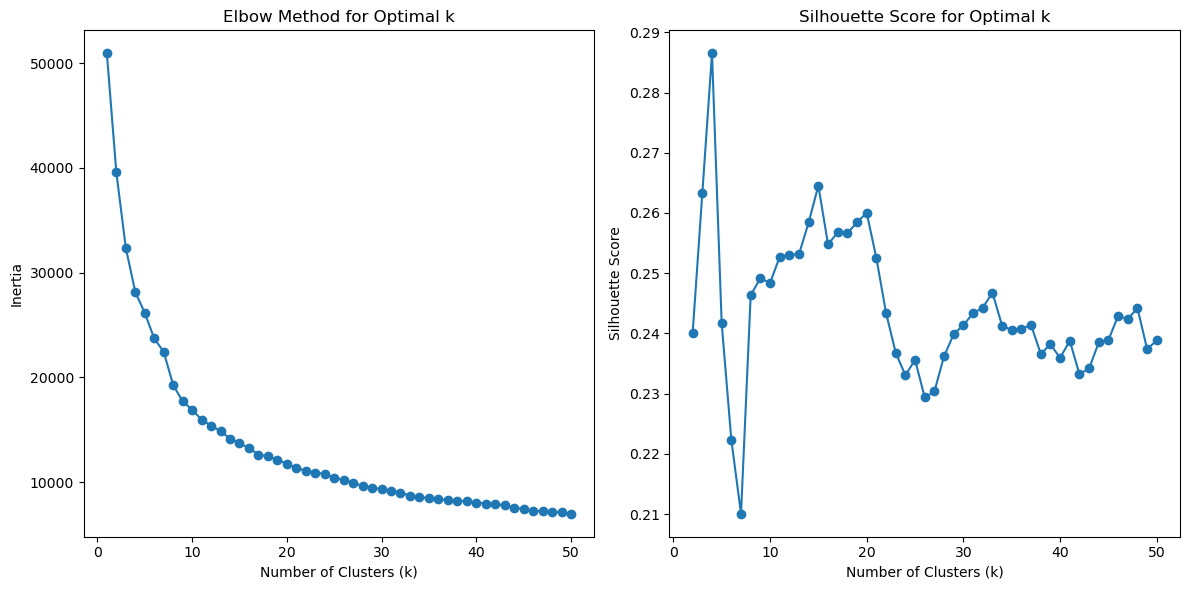

In [22]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define a range of k values to try
k_range = range(1, 51)  # Trying k values from 1 to 10

# For storing inertia and silhouette scores
inertia = []
sil_scores = []

# Loop through each value of k
for k in k_range:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_pca)  # Use your PCA-transformed data (x_pca)

    # Compute inertia for Elbow Method
    inertia.append(kmeans.inertia_)

    # Compute silhouette score
    if k > 1:  # Silhouette score is only defined for k > 1
        sil_score = silhouette_score(x_pca, labels)
        sil_scores.append(sil_score)
    else:
        sil_scores.append(-1)  # For k=1, silhouette score is undefined

# Plot the Elbow Method (Inertia vs. k)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Plot the Silhouette Scores (Silhouette Score vs. k)
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], sil_scores[1:], marker='o')  # Skip the first value (k=1)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()


In [24]:
#use n=20 based on this
kmeans = KMeans(n_clusters=20, random_state=42)  # Adjust clusters as needed
labels = kmeans.fit_predict(x_pca)

C:\Users\etien\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(


In [26]:
kmeans.labels_

array([12, 18,  4, ...,  0,  7,  7])

In [28]:
#set labels as a column in original df

In [30]:
df_player_play_motion = pd.read_csv('df_player_play_motion.csv')

In [32]:
df_player_play_motion['motion_label'] = kmeans.labels_

In [34]:
df_player_play_motion.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,max_x_rel_pos,min_x_rel_pos,max_y_rel_pos,min_y_rel_pos,dis_line_start,dis_line_end,max_dist_fb,min_dist_fb,passed_fb,motion_label
0,2022090800,80,47857,BUF,0,0,0,0,0,0,...,409,-2,-3,1069,668,-114,84,-988,0,12
1,2022090800,101,53079,BUF,0,0,0,0,0,0,...,0,-248,0,542,-325,-647,533,-3,0,18
2,2022090800,236,52536,BUF,0,0,0,0,0,1,...,4,-29,0,481,945,445,-582,-1082,1,4
3,2022090800,299,43399,LA,0,0,0,0,0,0,...,2,-165,495,0,-324,-805,12,-483,0,19
4,2022090800,299,44881,LA,0,0,0,0,0,0,...,238,0,0,621,746,123,-419,-1042,1,15


In [36]:
# Create a dictionary to hold DataFrames for each unique motion_label
motion_label_dfs = {label: df_player_play_motion[df_player_play_motion['motion_label'] == label] 
                     for label in df_player_play_motion['motion_label'].unique()}

In [38]:
# Get the row size of every DataFrame in motion_label_dfs
row_sizes = {label: df.shape[0] for label, df in motion_label_dfs.items()}
# Print the row sizes in numerical order, one per line
for label, size in sorted(row_sizes.items(), key=lambda item: item[1]):
    print(f'Motion Label: {label}, Row Size: {size}')

Motion Label: 16, Row Size: 2
Motion Label: 5, Row Size: 44
Motion Label: 12, Row Size: 56
Motion Label: 2, Row Size: 74
Motion Label: 10, Row Size: 75
Motion Label: 7, Row Size: 75
Motion Label: 14, Row Size: 78
Motion Label: 3, Row Size: 106
Motion Label: 18, Row Size: 155
Motion Label: 17, Row Size: 166
Motion Label: 8, Row Size: 185
Motion Label: 11, Row Size: 186
Motion Label: 19, Row Size: 190
Motion Label: 4, Row Size: 222
Motion Label: 9, Row Size: 258
Motion Label: 6, Row Size: 266
Motion Label: 15, Row Size: 269
Motion Label: 0, Row Size: 298
Motion Label: 13, Row Size: 310
Motion Label: 1, Row Size: 335


In [40]:
#example
motion_label_dfs[5][:10]

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,max_x_rel_pos,min_x_rel_pos,max_y_rel_pos,min_y_rel_pos,dis_line_start,dis_line_end,max_dist_fb,min_dist_fb,passed_fb,motion_label
6,2022090800,393,47853,LA,1,1,0,0,0,0,...,509,0,0,1769,1263,-502,216,-1552,0,5
64,2022091100,1260,39975,ATL,1,5,0,0,0,0,...,636,0,0,593,280,-289,24,-569,0,5
103,2022091101,184,44898,CLE,0,0,0,0,0,0,...,544,0,-13,1384,768,-212,328,-1085,0,5
123,2022091101,1192,44898,CLE,0,0,0,0,0,0,...,572,-4,2082,-3,876,-435,1223,-851,0,5
377,2022091105,1518,46173,IND,0,0,0,0,0,0,...,447,0,1449,0,1217,-103,1540,97,1,5
447,2022091106,2358,46277,MIA,1,8,0,0,0,0,...,633,0,-3,1552,688,-620,541,-1015,0,5
564,2022091108,2027,46071,NYG,1,4,0,0,0,0,...,462,0,0,1319,1004,-307,4,-1309,0,5
590,2022091109,767,44852,WAS,0,0,0,0,0,0,...,595,-1,0,1216,901,-317,15,-1204,0,5
733,2022091112,463,52430,MIN,0,0,0,0,0,0,...,566,0,1366,0,1052,-291,1363,-7,0,5
833,2022091200,2923,47987,SEA,0,0,0,0,0,0,...,474,0,-2,2262,1197,-1066,752,-1512,0,5


Observations after manually checking the results
- Double motion building off this [2022091100, 166]

- #may need to manually put in change in value columns for it to work with k-means

In [47]:
df_player_play_motion[(df_player_play_motion['gameId'] == 2022091100) & (df_player_play_motion['playId'] == 166)]

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,max_x_rel_pos,min_x_rel_pos,max_y_rel_pos,min_y_rel_pos,dis_line_start,dis_line_end,max_dist_fb,min_dist_fb,passed_fb,motion_label
48,2022091100,166,48374,ATL,0,0,0,0,0,0,...,88,-6,0,1607,665,-209,662,-942,0,1


In [45]:
#Export labels for every motion
df_player_play_motion.to_csv('player_play_motion_labels.csv',index=False)

#Create a short description for all 20 categories for the reader